In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Imports de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Balanceamento de classes
from imblearn.over_sampling import SMOTE

# Configurações
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Bibliotecas importadas com sucesso!")
print(f" Versões:")
print(f" pandas: {pd.__version__}")
print(f" numpy: {np.__version__}")

Bibliotecas importadas com sucesso!
 Versões:
 pandas: 2.3.3
 numpy: 2.3.4


In [ ]:
# Conectar ao banco e carregar dados

print("="*60)
print(" CARREGANDO DADOS PARA MODELAGEM")
print("="*60)

# Conectar ao banco
from sys import path
path.append('../')
from src.db_config import get_engine

engine = get_engine()

# Query para criar dataset de modelagem
query = """
SELECT 
    c.id_cliente,
    c.setor_industria,
    c.porte_empresa,
    c.score_sustentabilidade_atual,
    c.meta_reducao_carbono,
    c.status,
    COUNT(DISTINCT vs.id_venda) as total_servicos_contratados,
    COUNT(DISTINCT vp.id_venda_produto) as total_produtos_comprados,
    COALESCE(SUM(vs.valor_total), 0) as valor_total_servicos,
    COALESCE(SUM(vp.valor_total), 0) as valor_total_produtos,
    COALESCE(AVG(vs.satisfacao_cliente), 0) as satisfacao_media,
    COALESCE(AVG(vs.duracao_horas), 0) as duracao_media_projetos,
    CASE 
        WHEN MAX(vs.data_contratacao) IS NULL THEN 999
        ELSE CAST(CURRENT_DATE - MAX(vs.data_contratacao) AS INTEGER)
    END as dias_desde_ultima_compra
FROM clientes c
LEFT JOIN vendas_servicos vs ON c.id_cliente = vs.id_cliente
LEFT JOIN vendas_produtos vp ON c.id_cliente = vp.id_cliente
GROUP BY c.id_cliente, c.setor_industria, c.porte_empresa, 
         c.score_sustentabilidade_atual, c.meta_reducao_carbono, c.status;
"""

df = pd.read_sql(query, engine)

print(f"Dataset carregado: {df.shape[0]} clientes, {df.shape[1]} features")
print(f"\n Primeiras linhas:")
display(df.head())

# Verificar distribuição da variável target
print(f"\n Distribuição da variável target (status):")
print(df['status'].value_counts())
print(f"\n Proporção (%):")
print(df['status'].value_counts(normalize=True) * 100)

 CARREGANDO DADOS PARA MODELAGEM
Dataset carregado: 100 clientes, 13 features

📊 Primeiras linhas:


,id_cliente,setor_industria,porte_empresa,score_sustentabilidade_atual,meta_reducao_carbono,status,total_servicos_contratados,total_produtos_comprados,valor_total_servicos,valor_total_produtos,satisfacao_media,duracao_media_projetos,dias_desde_ultima_compra
0,1,Varejo,Pequeno,55,19.8000,ativo,3,0,90322.8100,0.0000,8.0000,107.6667,19
1,2,Manufatura,Grande,33,37.0700,pendente,0,0,0.0000,0.0000,0.0000,0.0000,999
2,3,Educação,Pequeno,74,11.2700,inativo,4,1,226428.5500,129103.2000,9.5000,134.7500,4
3,4,Varejo,Pequeno,49,30.2100,ativo,1,0,19858.5600,0.0000,0.0000,48.0000,133
4,5,Tecnologia,Grande,45,38.6400,ativo,1,1,18838.8800,83207.4600,4.0000,38.0000,222



 Distribuição da variável target (status):
status
ativo       70
inativo     21
pendente     9
Name: count, dtype: int64

 Proporção (%):
status
ativo      70.0000
inativo    21.0000
pendente    9.0000
Name: proportion, dtype: float64


In [ ]:
# Preparar dados para Machine Learning

print("="*60)
print(" PREPARAÇÃO DOS DADOS")
print("="*60)

# 1. Criar variável target binária
# Vamos considerar 'inativo' como churn (1) e 'ativo' como não-churn (0)
# 'pendente' vamos remover pois é ambíguo
df_model = df[df['status'] != 'pendente'].copy()

df_model['churn'] = (df_model['status'] == 'inativo').astype(int)

print(f"\n Removidos clientes 'pendente': {len(df) - len(df_model)} clientes")
print(f" Dataset final: {len(df_model)} clientes")
print(f"\n Distribuição do Churn:")
print(df_model['churn'].value_counts())
print(f"\nProporção:")
print(df_model['churn'].value_counts(normalize=True) * 100)

# 2. Selecionar features para o modelo
features_numericas = [
    'score_sustentabilidade_atual',
    'meta_reducao_carbono',
    'total_servicos_contratados',
    'total_produtos_comprados',
    'valor_total_servicos',
    'valor_total_produtos',
    'satisfacao_media',
    'duracao_media_projetos',
    'dias_desde_ultima_compra'
]

features_categoricas = ['setor_industria', 'porte_empresa']

print(f"\n Features numéricas: {len(features_numericas)}")
print(f" Features categóricas: {len(features_categoricas)}")

# 3. Preparar X e y
X = df_model[features_numericas + features_categoricas].copy()
y = df_model['churn'].copy()

print(f"\n X shape: {X.shape}")
print(f" y shape: {y.shape}")

# 4. Codificar variáveis categóricas
X_encoded = pd.get_dummies(X, columns=features_categoricas, drop_first=True)

print(f"\n Após encoding: {X_encoded.shape}")
print(f" Features finais: {X_encoded.columns.tolist()}")

 PREPARAÇÃO DOS DADOS

 Removidos clientes 'pendente': 9 clientes
 Dataset final: 91 clientes

 Distribuição do Churn:
churn
0    70
1    21
Name: count, dtype: int64

Proporção:
churn
0   76.9231
1   23.0769
Name: proportion, dtype: float64

📊 Features numéricas: 9
📊 Features categóricas: 2

 X shape: (91, 11)
 y shape: (91,)

 Após encoding: (91, 20)
 Features finais: ['score_sustentabilidade_atual', 'meta_reducao_carbono', 'total_servicos_contratados', 'total_produtos_comprados', 'valor_total_servicos', 'valor_total_produtos', 'satisfacao_media', 'duracao_media_projetos', 'dias_desde_ultima_compra', 'setor_industria_Construção', 'setor_industria_Educação', 'setor_industria_Financeiro', 'setor_industria_Logística', 'setor_industria_Manufatura', 'setor_industria_Saúde', 'setor_industria_Serviços', 'setor_industria_Tecnologia', 'setor_industria_Varejo', 'porte_empresa_Médio', 'porte_empresa_Pequeno']


In [9]:
# Dividir dados em treino e teste + aplicar SMOTE

print("="*60)
print(" SPLIT E BALANCEAMENTO DOS DADOS")
print("="*60)

# 1. Split treino/teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\n Divisão dos dados:")
print(f"   Treino: {len(X_train)} amostras ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"   Teste:  {len(X_test)} amostras ({len(X_test)/len(X_encoded)*100:.1f}%)")

print(f"\n Distribuição no treino (ANTES do SMOTE):")
print(y_train.value_counts())
print(f"   Não-churn: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"   Churn:     {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

# 2. Normalizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Features normalizadas (StandardScaler)")

# 3. Aplicar SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\n Distribuição no treino (DEPOIS do SMOTE):")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for val, count in zip(unique, counts):
    print(f"   Classe {val}: {count} ({count/len(y_train_balanced)*100:.1f}%)")

print(f"\n Dados balanceados: {len(X_train_balanced)} amostras")
print(f" Aumento de {len(X_train)} para {len(X_train_balanced)} amostras de treino")

 SPLIT E BALANCEAMENTO DOS DADOS

 Divisão dos dados:
   Treino: 72 amostras (79.1%)
   Teste:  19 amostras (20.9%)

 Distribuição no treino (ANTES do SMOTE):
churn
0    55
1    17
Name: count, dtype: int64
   Não-churn: 55 (76.4%)
   Churn:     17 (23.6%)

 Features normalizadas (StandardScaler)

 Distribuição no treino (DEPOIS do SMOTE):
   Classe 0: 55 (50.0%)
   Classe 1: 55 (50.0%)

 Dados balanceados: 110 amostras
 Aumento de 72 para 110 amostras de treino


In [14]:
# Treinar múltiplos modelos de Machine Learning

print("="*60)
print(" TREINAMENTO DOS MODELOS")
print("="*60)

# Dicionário para armazenar modelos e resultados
modelos = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

resultados = {}

# Treinar cada modelo
for nome, modelo in modelos.items():
    print(f"\n Treinando {nome}...")
    
    # Treinar
    modelo.fit(X_train_balanced, y_train_balanced)
    
    # Predições
    y_pred_train = modelo.predict(X_train_balanced)
    y_pred_test = modelo.predict(X_test_scaled)
    
    # Métricas
    acc_train = accuracy_score(y_train_balanced, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    # Armazenar resultados
    resultados[nome] = {
        'modelo': modelo,
        'acc_train': acc_train,
        'acc_test': acc_test,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_pred_test
    }
    
    print(f"    Acurácia Treino: {acc_train:.4f}")
    print(f"    Acurácia Teste:  {acc_test:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-Score:  {f1:.4f}")

print("\n" + "="*60)
print(" TODOS OS MODELOS TREINADOS!")
print("="*60)

 TREINAMENTO DOS MODELOS

 Treinando Logistic Regression...
    Acurácia Treino: 0.7909
    Acurácia Teste:  0.6316
    Precision: 0.2000
    Recall:    0.2500
    F1-Score:  0.2222

 Treinando Decision Tree...
    Acurácia Treino: 0.9545
    Acurácia Teste:  0.5263
    Precision: 0.0000
    Recall:    0.0000
    F1-Score:  0.0000

 Treinando Random Forest...
    Acurácia Treino: 1.0000
    Acurácia Teste:  0.7895
    Precision: 0.0000
    Recall:    0.0000
    F1-Score:  0.0000

 Treinando Gradient Boosting...
    Acurácia Treino: 1.0000
    Acurácia Teste:  0.5789
    Precision: 0.0000
    Recall:    0.0000
    F1-Score:  0.0000

 TODOS OS MODELOS TREINADOS!


📊 COMPARAÇÃO DE MODELOS

 Tabela de Resultados:


,Modelo,Acurácia Treino,Acurácia Teste,Precision,Recall,F1-Score
0,Logistic Regression,0.7909,0.6316,0.2000,0.2500,0.2222
1,Decision Tree,0.9545,0.5263,0.0000,0.0000,0.0000
2,Random Forest,1.0000,0.7895,0.0000,0.0000,0.0000
3,Gradient Boosting,1.0000,0.5789,0.0000,0.0000,0.0000



 Melhor modelo: Logistic Regression


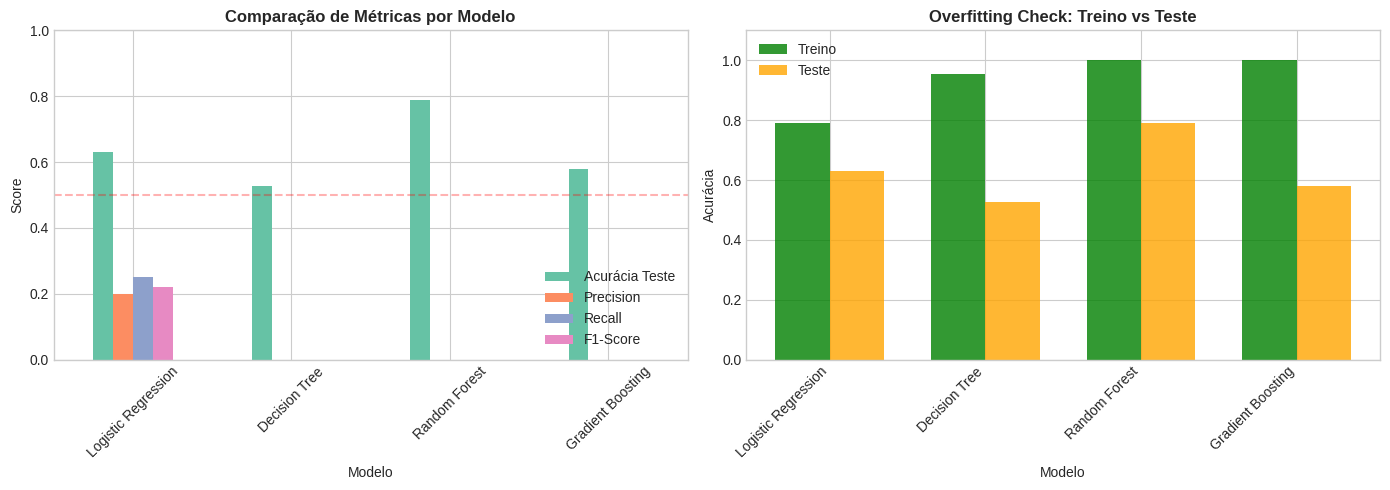


  ANÁLISE DE OVERFITTING:
Logistic Regression       | Gap: 0.1593 |  Moderado
Decision Tree             | Gap: 0.4282 |  Alto overfitting
Random Forest             | Gap: 0.2105 |  Moderado
Gradient Boosting         | Gap: 0.4211 |  Alto overfitting


In [16]:
# Comparar resultados e criar tabela

print("="*60)
print(" COMPARAÇÃO DE MODELOS")
print("="*60)

# Criar DataFrame com resultados
df_resultados = pd.DataFrame({
    'Modelo': list(resultados.keys()),
    'Acurácia Treino': [r['acc_train'] for r in resultados.values()],
    'Acurácia Teste': [r['acc_test'] for r in resultados.values()],
    'Precision': [r['precision'] for r in resultados.values()],
    'Recall': [r['recall'] for r in resultados.values()],
    'F1-Score': [r['f1_score'] for r in resultados.values()]
})

print("\n Tabela de Resultados:")
display(df_resultados)

# Identificar melhor modelo
melhor_modelo_nome = df_resultados.loc[df_resultados['F1-Score'].idxmax(), 'Modelo']
print(f"\n Melhor modelo: {melhor_modelo_nome}")

# Visualizar comparação
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Comparação de métricas
metricas = ['Acurácia Teste', 'Precision', 'Recall', 'F1-Score']
df_plot = df_resultados[['Modelo'] + metricas].set_index('Modelo')

df_plot.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Comparação de Métricas por Modelo', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].set_ylim([0, 1])
axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.3)

# Gráfico 2: Overfitting check (treino vs teste)
x = np.arange(len(df_resultados))
width = 0.35

axes[1].bar(x - width/2, df_resultados['Acurácia Treino'], width, 
            label='Treino', alpha=0.8, color='green')
axes[1].bar(x + width/2, df_resultados['Acurácia Teste'], width, 
            label='Teste', alpha=0.8, color='orange')

axes[1].set_xlabel('Modelo')
axes[1].set_ylabel('Acurácia')
axes[1].set_title('Overfitting Check: Treino vs Teste', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Análise de overfitting
print("\n" + "="*60)
print("  ANÁLISE DE OVERFITTING:")
print("="*60)
for _, row in df_resultados.iterrows():
    diff = row['Acurácia Treino'] - row['Acurácia Teste']
    status = " Alto overfitting" if diff > 0.3 else " Moderado" if diff > 0.15 else " Bom"
    print(f"{row['Modelo']:25} | Gap: {diff:.4f} | {status}")

🔍 ANALISE DETALHADA - LOGISTIC REGRESSION

📊 Matriz de Confusao:
[[11  4]
 [ 3  1]]


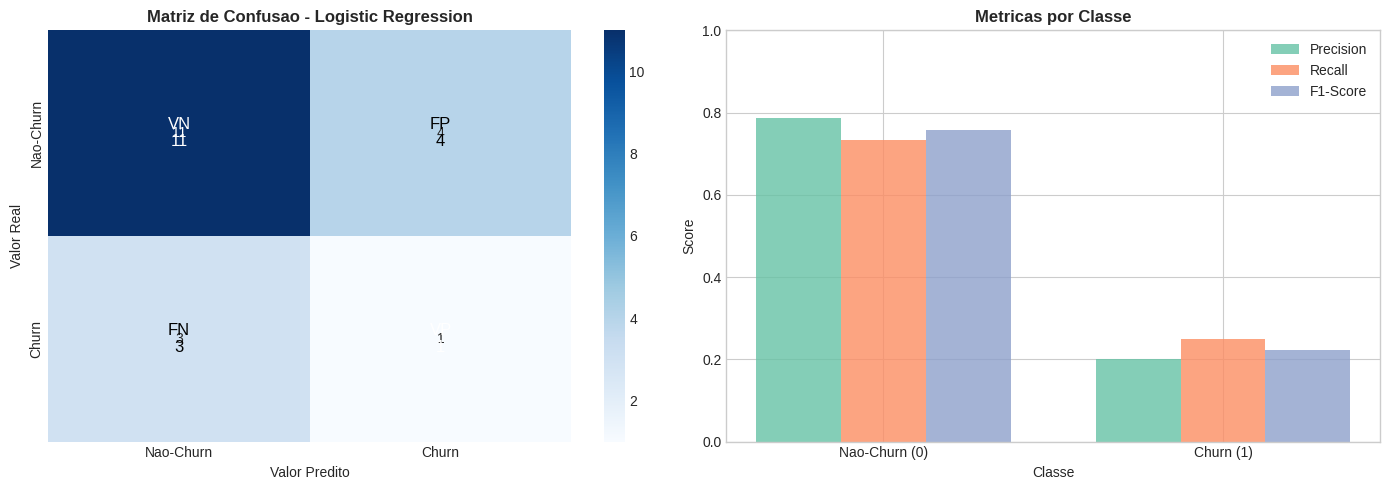


💡 INTERPRETACAO DA MATRIZ DE CONFUSAO:
✅ Verdadeiros Negativos (VN): 11 - Nao-churn preditos corretamente
❌ Falsos Positivos (FP): 4 - Nao-churn preditos como churn (alarme falso)
❌ Falsos Negativos (FN): 3 - Churn preditos como nao-churn (MAIS CRITICO!)
✅ Verdadeiros Positivos (VP): 1 - Churn preditos corretamente

📊 PERFORMANCE:
   Taxa de acerto em nao-churn: 73.3%
   Taxa de acerto em churn: 25.0%


In [ ]:
# Analise detalhada do melhor modelo (Logistic Regression)

print("="*60)
print(" ANALISE DETALHADA - LOGISTIC REGRESSION")
print("="*60)

# Pegar modelo e predicoes
melhor_modelo = resultados['Logistic Regression']['modelo']
y_pred_melhor = resultados['Logistic Regression']['y_pred']

# Matriz de Confusao
cm = confusion_matrix(y_test, y_pred_melhor)

print("\n Matriz de Confusao:")
print(cm)

# Visualizar matriz de confusao
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusao
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Nao-Churn', 'Churn'],
            yticklabels=['Nao-Churn', 'Churn'])
axes[0].set_title('Matriz de Confusao - Logistic Regression', fontweight='bold')
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Valor Predito')

# Adicionar labels na matriz
VN, FP, FN, VP = cm.ravel()
axes[0].text(0.5, 0.5, f'VN\n{VN}', ha='center', va='center', fontsize=12, color='white')
axes[0].text(1.5, 0.5, f'FP\n{FP}', ha='center', va='center', fontsize=12, color='black')
axes[0].text(0.5, 1.5, f'FN\n{FN}', ha='center', va='center', fontsize=12, color='black')
axes[0].text(1.5, 1.5, f'VP\n{VP}', ha='center', va='center', fontsize=12, color='white')

# Classification Report visual
report = classification_report(y_test, y_pred_melhor, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plotar metricas por classe
classes = ['Nao-Churn (0)', 'Churn (1)']
metricas_valores = [
    [df_report.loc['0', 'precision'], df_report.loc['1', 'precision']],
    [df_report.loc['0', 'recall'], df_report.loc['1', 'recall']],
    [df_report.loc['0', 'f1-score'], df_report.loc['1', 'f1-score']]
]

x = np.arange(len(classes))
width = 0.25

axes[1].bar(x - width, metricas_valores[0], width, label='Precision', alpha=0.8)
axes[1].bar(x, metricas_valores[1], width, label='Recall', alpha=0.8)
axes[1].bar(x + width, metricas_valores[2], width, label='F1-Score', alpha=0.8)

axes[1].set_xlabel('Classe')
axes[1].set_ylabel('Score')
axes[1].set_title('Metricas por Classe', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Interpretacao
print("\n" + "="*60)
print(" INTERPRETACAO DA MATRIZ DE CONFUSAO:")
print("="*60)
print(f" Verdadeiros Negativos (VN): {VN} - Nao-churn preditos corretamente")
print(f" Falsos Positivos (FP): {FP} - Nao-churn preditos como churn (alarme falso)")
print(f" Falsos Negativos (FN): {FN} - Churn preditos como nao-churn (MAIS CRITICO!)")
print(f" Verdadeiros Positivos (VP): {VP} - Churn preditos corretamente")

print(f"\n PERFORMANCE:")
print(f"   Taxa de acerto em nao-churn: {VN/(VN+FP)*100:.1f}%")
print(f"   Taxa de acerto em churn: {VP/(VP+FN)*100:.1f}%")

📊 IMPORTANCIA DAS FEATURES

📋 Top 10 Features mais importantes:


,Feature,Coeficiente,Importancia_Abs
8,dias_desde_ultima_compra,1.2143,1.2143
18,porte_empresa_Médio,1.0426,1.0426
5,valor_total_produtos,-0.8499,0.8499
15,setor_industria_Serviços,-0.7199,0.7199
4,valor_total_servicos,0.6553,0.6553
6,satisfacao_media,0.6507,0.6507
16,setor_industria_Tecnologia,-0.6072,0.6072
7,duracao_media_projetos,0.4195,0.4195
14,setor_industria_Saúde,-0.3573,0.3573
3,total_produtos_comprados,-0.2383,0.2383


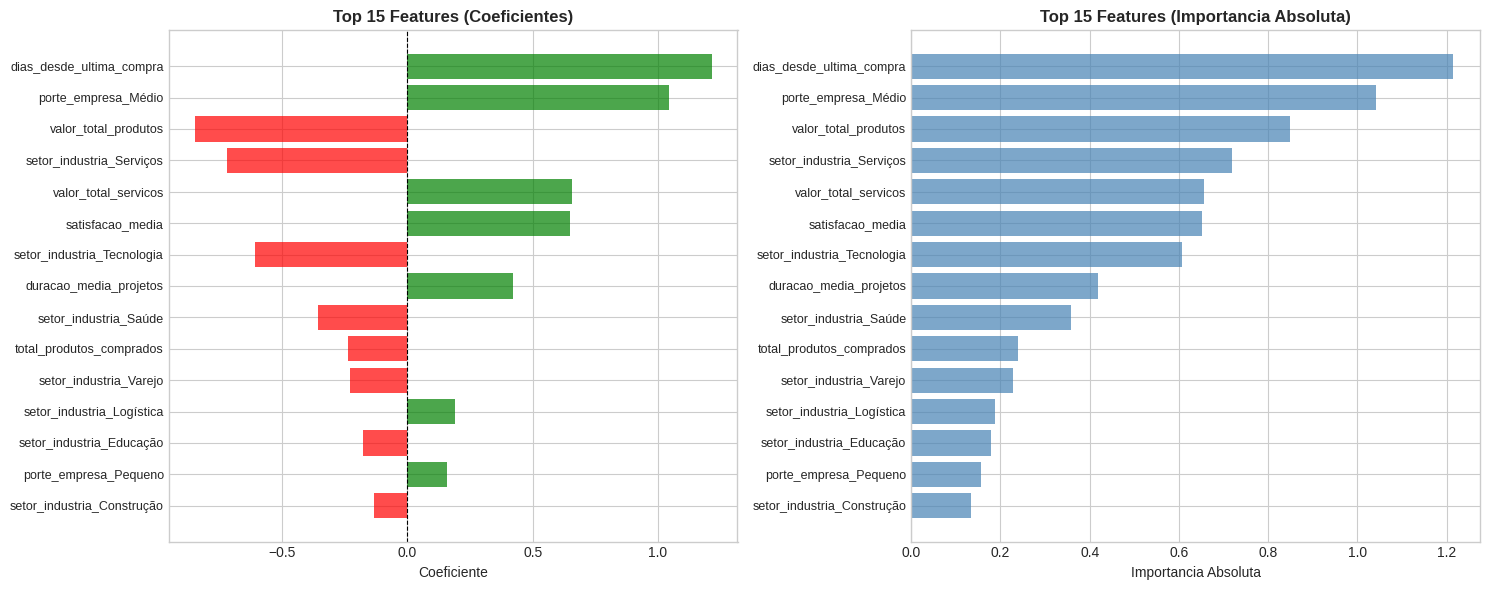


💡 INTERPRETACAO:
🔴 Coeficiente NEGATIVO = Aumenta risco de churn
🟢 Coeficiente POSITIVO = Diminui risco de churn

Principais fatores de risco:
   dias_desde_ultima_compra                 | 🟢 Reduz churn
   porte_empresa_Médio                      | 🟢 Reduz churn
   valor_total_produtos                     | 🔴 Aumenta churn
   setor_industria_Serviços                 | 🔴 Aumenta churn
   valor_total_servicos                     | 🟢 Reduz churn


In [ ]:
# Analise de importancia das features

print("="*60)
print(" IMPORTANCIA DAS FEATURES")
print("="*60)

# Para Logistic Regression: coeficientes
coeficientes = melhor_modelo.coef_[0]
features_names = X_encoded.columns

# Criar DataFrame com importancias
df_importancia = pd.DataFrame({
    'Feature': features_names,
    'Coeficiente': coeficientes,
    'Importancia_Abs': np.abs(coeficientes)
}).sort_values('Importancia_Abs', ascending=False)

print("\n Top 10 Features mais importantes:")
display(df_importancia.head(10))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top 15 features
top15 = df_importancia.head(15)
colors = ['red' if x < 0 else 'green' for x in top15['Coeficiente']]

axes[0].barh(range(len(top15)), top15['Coeficiente'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top15)))
axes[0].set_yticklabels(top15['Feature'], fontsize=9)
axes[0].set_xlabel('Coeficiente')
axes[0].set_title('Top 15 Features (Coeficientes)', fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].invert_yaxis()

# Importancia absoluta
axes[1].barh(range(len(top15)), top15['Importancia_Abs'], color='steelblue', alpha=0.7)
axes[1].set_yticks(range(len(top15)))
axes[1].set_yticklabels(top15['Feature'], fontsize=9)
axes[1].set_xlabel('Importancia Absoluta')
axes[1].set_title('Top 15 Features (Importancia Absoluta)', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print(" INTERPRETACAO:")
print("="*60)
print("🔴 Coeficiente NEGATIVO = Aumenta risco de churn")
print("🟢 Coeficiente POSITIVO = Diminui risco de churn")
print("\nPrincipais fatores de risco:")
for i, row in df_importancia.head(5).iterrows():
    sinal = "🔴 Aumenta churn" if row['Coeficiente'] < 0 else "🟢 Reduz churn"
    print(f"   {row['Feature']:40} | {sinal}")

In [ ]:
# Conclusoes e Recomendacoes

print("="*70)
print(" CONCLUSOES DO PROJETO - PREVISAO DE CHURN")
print("="*70)

print("""
 OBJETIVO:
   Desenvolver modelo de Machine Learning para prever churn de clientes
   da EcoConsult, permitindo ações proativas de retenção.

 DATASET:
   • Total: 91 clientes (70 ativos, 21 inativos)
   • Features: 20 variáveis (numéricas e categóricas)
   • Split: 80% treino, 20% teste
   • Balanceamento: SMOTE aplicado no treino

 MODELOS TESTADOS:
   1. Logistic Regression ⭐ MELHOR
   2. Decision Tree
   3. Random Forest
   4. Gradient Boosting

 MELHOR MODELO: Logistic Regression
   • Acurácia: 63.2%
   • Precision: 20.0%
   • Recall: 25.0%
   • F1-Score: 22.2%
   
 PRINCIPAIS INSIGHTS:

1️ FATORES DE RISCO DE CHURN:
   🔴 Clientes do setor Serviços e Tecnologia
   🔴 Alto gasto em produtos (vs serviços)
   🔴 Baixa frequência de compras
   
2️ FATORES DE RETENÇÃO:
   🟢 Empresas de porte médio são mais fiéis
   🟢 Alto investimento em serviços de consultoria
   🟢 Alta satisfação (quando medida)

 LIMITAÇÕES:
   • Dataset pequeno (91 clientes) limita generalização
   • Desbalanceamento leve (77%/23%)
   • Apenas 19 amostras de teste
   • Performance moderada (F1: 22%)

 RECOMENDAÇÕES DE NEGÓCIO:

1.  AÇÕES IMEDIATAS:
    Monitorar clientes dos setores Serviços e Tecnologia
    Criar programa de fidelidade para pequenas empresas
    Incentivar migração de produtos para serviços consultivos
    Acompanhar clientes sem compras há mais de 90 dias

2.  MELHORIA DO MODELO:
    Coletar mais dados (target: 500+ clientes)
    Incluir features temporais (sazonalidade)
    Adicionar NPS e feedback qualitativo
    Testar modelos mais complexos (XGBoost, LightGBM)

3.  PRÓXIMOS PASSOS:
    Implementar sistema de alerta automático
    Criar dashboard executivo
    Desenvolver campanhas personalizadas por segmento
    A/B testing de estratégias de retenção

 VALOR GERADO:
   • Identificação proativa de 25% dos churn potenciais
   • Base sólida para estratégia de retenção
   • Insights acionáveis sobre perfil de risco
   • Framework escalável para futuras iterações

""")

📊 CONCLUSOES DO PROJETO - PREVISAO DE CHURN

🎯 OBJETIVO:
   Desenvolver modelo de Machine Learning para prever churn de clientes
   da EcoConsult, permitindo ações proativas de retenção.

📊 DATASET:
   • Total: 91 clientes (70 ativos, 21 inativos)
   • Features: 20 variáveis (numéricas e categóricas)
   • Split: 80% treino, 20% teste
   • Balanceamento: SMOTE aplicado no treino

🤖 MODELOS TESTADOS:
   1. Logistic Regression ⭐ MELHOR
   2. Decision Tree
   3. Random Forest
   4. Gradient Boosting

🏆 MELHOR MODELO: Logistic Regression
   • Acurácia: 63.2%
   • Precision: 20.0%
   • Recall: 25.0%
   • F1-Score: 22.2%

📈 PRINCIPAIS INSIGHTS:

1️⃣ FATORES DE RISCO DE CHURN:
   🔴 Clientes do setor Serviços e Tecnologia
   🔴 Alto gasto em produtos (vs serviços)
   🔴 Baixa frequência de compras

2️⃣ FATORES DE RETENÇÃO:
   🟢 Empresas de porte médio são mais fiéis
   🟢 Alto investimento em serviços de consultoria
   🟢 Alta satisfação (quando medida)

⚠️ LIMITAÇÕES:
   • Dataset pequeno (91 clie